# **Model Selection**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))
    
    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_
    
    return result

def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



# Assuming create_lstm_model and Model_training functions are defined elsewhere correctly

def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []
    
    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    params_lr = {'regressor__fit_intercept': [True, False]}
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lr, ignore_index=True)

    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([('regressor', Lasso())])
    params_lasso = {'regressor__alpha': [0.5, 1], 'regressor__max_iter': [1000]}
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lasso, ignore_index=True)

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_rf, ignore_index=True)
  
    # LSTM model training with dynamic input shape handling
    print('\n\n# LSTM')
    # Initialize the scaler for features
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    # Initialize the scaler for target variable
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))
    
    
    params_lstm = {
        'batch_size': [32, 64],
        'epochs': [50, 100],
        'optimizer': ['adam'],
    }

    # Determine input shape dynamically based on current dataset
     # Adjusted for variable number of features and correct index for feature dimension
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
    # Update KerasRegressor to pass dynamic input shape correctly
    lstm_model = KerasRegressor(model=lambda: create_lstm_model(input_shape=input_shape), verbose=0, epochs=100, batch_size=32)

    model_lstm = GridSearchCV(estimator=lstm_model, param_grid=params_lstm, cv=cv, verbose=verbose)
    result_lstm = Model_training(model_lstm, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, pred_list)
    Results = Results.append(result_lstm, ignore_index=True)

    # Ensure model_name is defined before this line and has correct mappings
    # Results.index = [model_name[i] for i in range(len(Results))]  # Adjust index mapping based on actual models

    return Results, pred_list, scaler_x, scaler_y

In [7]:
model_name = {0: 'Linear Regression', 1: 'Lasso', 2: 'Random Forest', 3: 'LSTM'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}


# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])

# Without Feature Engineering
print('####### Without Feature Engineering #######')
# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])



#print(f'############################################\n\n trial: {trial}\n\n ############################################')

results_total = []

# Models Training
Results, pred_list, scaler_x, scaler_y = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list, scaler_x, scaler_y = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list, scaler_x, scaler_y = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list, scaler_x, scaler_y = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

#results_.to_csv(f'./Model performance/results_{trial}.csv')


lstm_predictions_scaled = pred_list[-1]
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled)




####### Without Feature Engineering #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s


# Lasso
Fitting 5 folds for each of 2 candidates, totalling 10

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
2024-03-07 16:23:37.535846: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-07 16:23:37.535874: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-07 16:23:37.535883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-07 16:23:37.536194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not id



# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


2024-03-07 16:23:38.983927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   9.3s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  16.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  20.5s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  29.4s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  35.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  17.3s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  29.3s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  43.7s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.0min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.2min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   7.7s
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  11.2s
[CV] END ...........batch_si

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


Results    Train MAE  Train RMSE  Test MAE  Test RMSE  \
0   1.483713    2.185955  2.103814   2.657183   
1   1.483569    2.214203  1.680404   2.190981   
2   0.902765    1.305933  9.214915  11.584865   
3   0.018104    0.025864  0.073274   0.084805   

                                                                                                           Best Params  
0                                                                                   {'regressor__fit_intercept': True}  
1                                                               {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
2  {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 200}  
3                                                                {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}  
pred_list [array([[ 42.66996931],
       [ 42.97928086],
       [ 43.08370309],
       ...,
       [193.49644393],
       [193.27322842],
   

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  11.9s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  23.2s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  27.4s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  34.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  46.1s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  20.7s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  36.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  54.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.1min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.3min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  10.4s
[CV] END ...........batch_size=64, epoch

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected



##################################################
Boruta
   Train MAE  Train RMSE  Test MAE  Test RMSE  \
0   1.479221    2.206673  1.814506   2.350119   
1   1.484431    2.221659  1.678116   2.190818   
2   0.567852    0.857711  9.006152  11.508977   
3   0.016952    0.023568  0.062723   0.073641   

                                                                                                            Best Params  
0                                                                                    {'regressor__fit_intercept': True}  
1                                                                {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
2  {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
3                                                                 {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}  

####### PCA #######


# Linear Regression
Fitting 5 folds for each of 2 candidates,

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  17.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  28.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  31.7s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  47.5s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  57.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  29.2s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  45.7s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  58.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.2min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.5min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  14.1s
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  17.7s
[CV] END ...........batch_si

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected



##################################################
PCA
   Train MAE  Train RMSE   Test MAE  Test RMSE  \
0   1.925108    2.693755  75.588110  80.690876   
1   2.077837    2.850734  75.588110  80.643630   
2   1.112652    1.574623  69.197809  72.890880   
3   0.017540    0.024116   0.509214   0.539066   

                                                                                                            Best Params  
0                                                                                    {'regressor__fit_intercept': True}  
1                                                                {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
2  {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
3                                                                 {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}  

####### t-SNE #######


# Linear Regression
Fitting 5 folds for each of 2 candida

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  18.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  30.5s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  39.9s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  44.3s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time= 1.1min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  37.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  47.1s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.3min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.4min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 2.0min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  15.4s
[CV] END ...........batch_size=64, epoch

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_16336/3179703214.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)


In [ ]:
# Visualization
# Before your plotting code, you can adjust the default plot size like this
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)
# For each subplot, you can now set individual titles and labels without them overlapping.
for key, value in model_name.items():
    ax = plt.subplot(2, 2, key + 1)
    model = key
    ax.set_title(value)
    plt.plot(y_actual, label='Actual')
    for key, value in pred_total.items():
        plt.plot(date, value[model], label=key)
    
    # Ensure the x parameter matches the format and actual point where the test data starts
    plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
    
    # Rotate xticks if they are overlapping
    
    # Set xticks to be more sparse to prevent overlap
    #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
    plt.xticks(axis_x)
    plt.legend()

# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.suptitle('Results Comparison (Predicted Day 1)', fontsize=16)

# Show the plot
plt.show()

In [8]:
pred_total

{'Without Feature Engineering': [array([[ 42.66996931],
         [ 42.97928086],
         [ 43.08370309],
         ...,
         [193.49644393],
         [193.27322842],
         [192.91755568]]),
  array([ 43.01570071,  43.12845812,  43.30113045, ..., 194.89709684,
         194.3899658 , 194.11892398]),
  array([ 43.28206304,  43.41597486,  43.7091038 , ..., 173.64496587,
         173.35408559, 173.23277961]),
  array([[0.06276288],
         [0.06197665],
         [0.06368831],
         ...,
         [0.95591867],
         [0.9564498 ],
         [0.95577097]], dtype=float32)],
 'Boruta': [array([[ 43.01284261],
         [ 43.02776368],
         [ 43.2567565 ],
         ...,
         [194.16349273],
         [193.95706211],
         [193.78086004]]),
  array([ 43.1982673 ,  43.19385385,  43.40238162, ..., 194.9239071 ,
         194.35348226, 194.07538037]),
  array([ 43.12459938,  43.24992484,  43.71147501, ..., 173.16359893,
         172.97339886, 172.83859874]),
  array([[0.05913952]

In [9]:
for method, predictions in pred_total.items():
    print(f"{method} predictions: {predictions.shape[0]}")

AttributeError: 'list' object has no attribute 'shape'

In [10]:
for fe_method, predictions_list in pred_total.items():
    total_predictions = 0  # Initialize counter for total predictions for the current FE method
    print(f"\nFeature Engineering Method: {fe_method}")
    
    # Iterate through the list of arrays for each FE method
    for idx, predictions in enumerate(predictions_list, start=1):
        # Check if predictions are in a two-dimensional array and need flattening
        if predictions.ndim > 1:
            predictions = predictions.flatten()
        
        print(f"  Array {idx}: {predictions.shape[0]} predictions")
        total_predictions += predictions.shape[0]

    print(f"Total predictions for {fe_method}: {total_predictions}")



Feature Engineering Method: Without Feature Engineering
  Array 1: 1526 predictions
  Array 2: 1526 predictions
  Array 3: 1526 predictions
  Array 4: 1526 predictions
Total predictions for Without Feature Engineering: 6104

Feature Engineering Method: Boruta
  Array 1: 1526 predictions
  Array 2: 1526 predictions
  Array 3: 1526 predictions
  Array 4: 1526 predictions
Total predictions for Boruta: 6104

Feature Engineering Method: PCA
  Array 1: 1526 predictions
  Array 2: 1526 predictions
  Array 3: 1526 predictions
  Array 4: 1526 predictions
Total predictions for PCA: 6104

Feature Engineering Method: tSNE
  Array 1: 1526 predictions
  Array 2: 1526 predictions
  Array 3: 1526 predictions
  Array 4: 1526 predictions
Total predictions for tSNE: 6104


####### Without Feature Engineering #######
############################################

 trial: 1

 ############################################


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__f

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
2024-03-06 20:43:11.067915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-06 20:43:11.067938: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-06 20:43:11.067944: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-06 20:43:11.068176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not id



# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


2024-03-06 20:43:12.490141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  10.3s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  15.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  21.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  29.5s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  35.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  17.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  31.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  43.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  59.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.2min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   7.9s
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  11.1s
[CV] END ...........batch_si

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


Results    Train MAE  Train RMSE  Test MAE  Test RMSE  \
0   1.483713    2.185955  2.103814   2.657183   
1   1.483569    2.214203  1.680404   2.190981   
2   0.577567    0.868583  9.297994  11.644006   
3   0.016287    0.022111  0.059631   0.070492   

                                         Best Params  
0                 {'regressor__fit_intercept': True}  
1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
2  {'criterion': 'squared_error', 'max_depth': 16...  
3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  
pred_list [array([[ 42.66996931],
       [ 42.97928086],
       [ 43.08370309],
       ...,
       [193.49644393],
       [193.27322842],
       [192.91755568]]), array([ 43.01570071,  43.12845812,  43.30113045, ..., 194.89709684,
       194.3899658 , 194.11892398]), array([ 43.14787447,  43.31661994,  43.68959302, ..., 173.55539943,
       173.35849987, 173.10454974]), array([[0.06475343],
       [0.06488648],
       [0.06693727],
       ...,
       [0.9746077 ],
  

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  12.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  20.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  25.3s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  33.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  44.9s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  19.5s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  39.7s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  53.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.1min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.5min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.0s
[CV] END ...........batch_size=64, epoch

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected



##################################################
Boruta
   Train MAE  Train RMSE  Test MAE  Test RMSE  \
0   1.479221    2.206673  1.814506   2.350119   
1   1.484431    2.221659  1.678116   2.190818   
2   0.558981    0.834292  9.265825  11.757415   
3   0.017911    0.024599  0.064805   0.075577   

                                         Best Params  
0                 {'regressor__fit_intercept': True}  
1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
2  {'criterion': 'squared_error', 'max_depth': 16...  
3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  

####### PCA #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  16.8s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  25.7s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  34.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  37.8s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  51.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  27.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  45.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.0min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.4min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.8min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  12.5s
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  17.9s
[CV] END ...........batch_si

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected



##################################################
PCA
   Train MAE  Train RMSE   Test MAE  Test RMSE  \
0   1.925108    2.693755  75.588110  80.690876   
1   2.077837    2.850734  75.588110  80.643630   
2   1.201432    1.706148  68.883953  72.562272   
3   0.015957    0.022695   0.504704   0.534428   

                                         Best Params  
0                 {'regressor__fit_intercept': True}  
1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
2  {'criterion': 'squared_error', 'max_depth': 16...  
3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  

####### t-SNE #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total t

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataCon

[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  19.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  26.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  33.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  46.5s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  58.9s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  29.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  51.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  58.7s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.3min
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.6min
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  15.6s
[CV] END ...........batch_size=64, epoch

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_96392/4183513230.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)




##################################################
t-SNE
   Train MAE  Train RMSE   Test MAE  Test RMSE  \
0  12.969487   15.906425  72.819892  77.302222   
1  12.968160   15.907869  72.814629  77.303395   
2   1.184341    1.693092  74.408502  81.992195   
3   0.034654    0.046061   0.484590   0.535494   

                                         Best Params  
0                 {'regressor__fit_intercept': True}  
1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
2  {'criterion': 'squared_error', 'max_depth': 24...  
3  {'batch_size': 32, 'epochs': 100, 'optimizer':...  


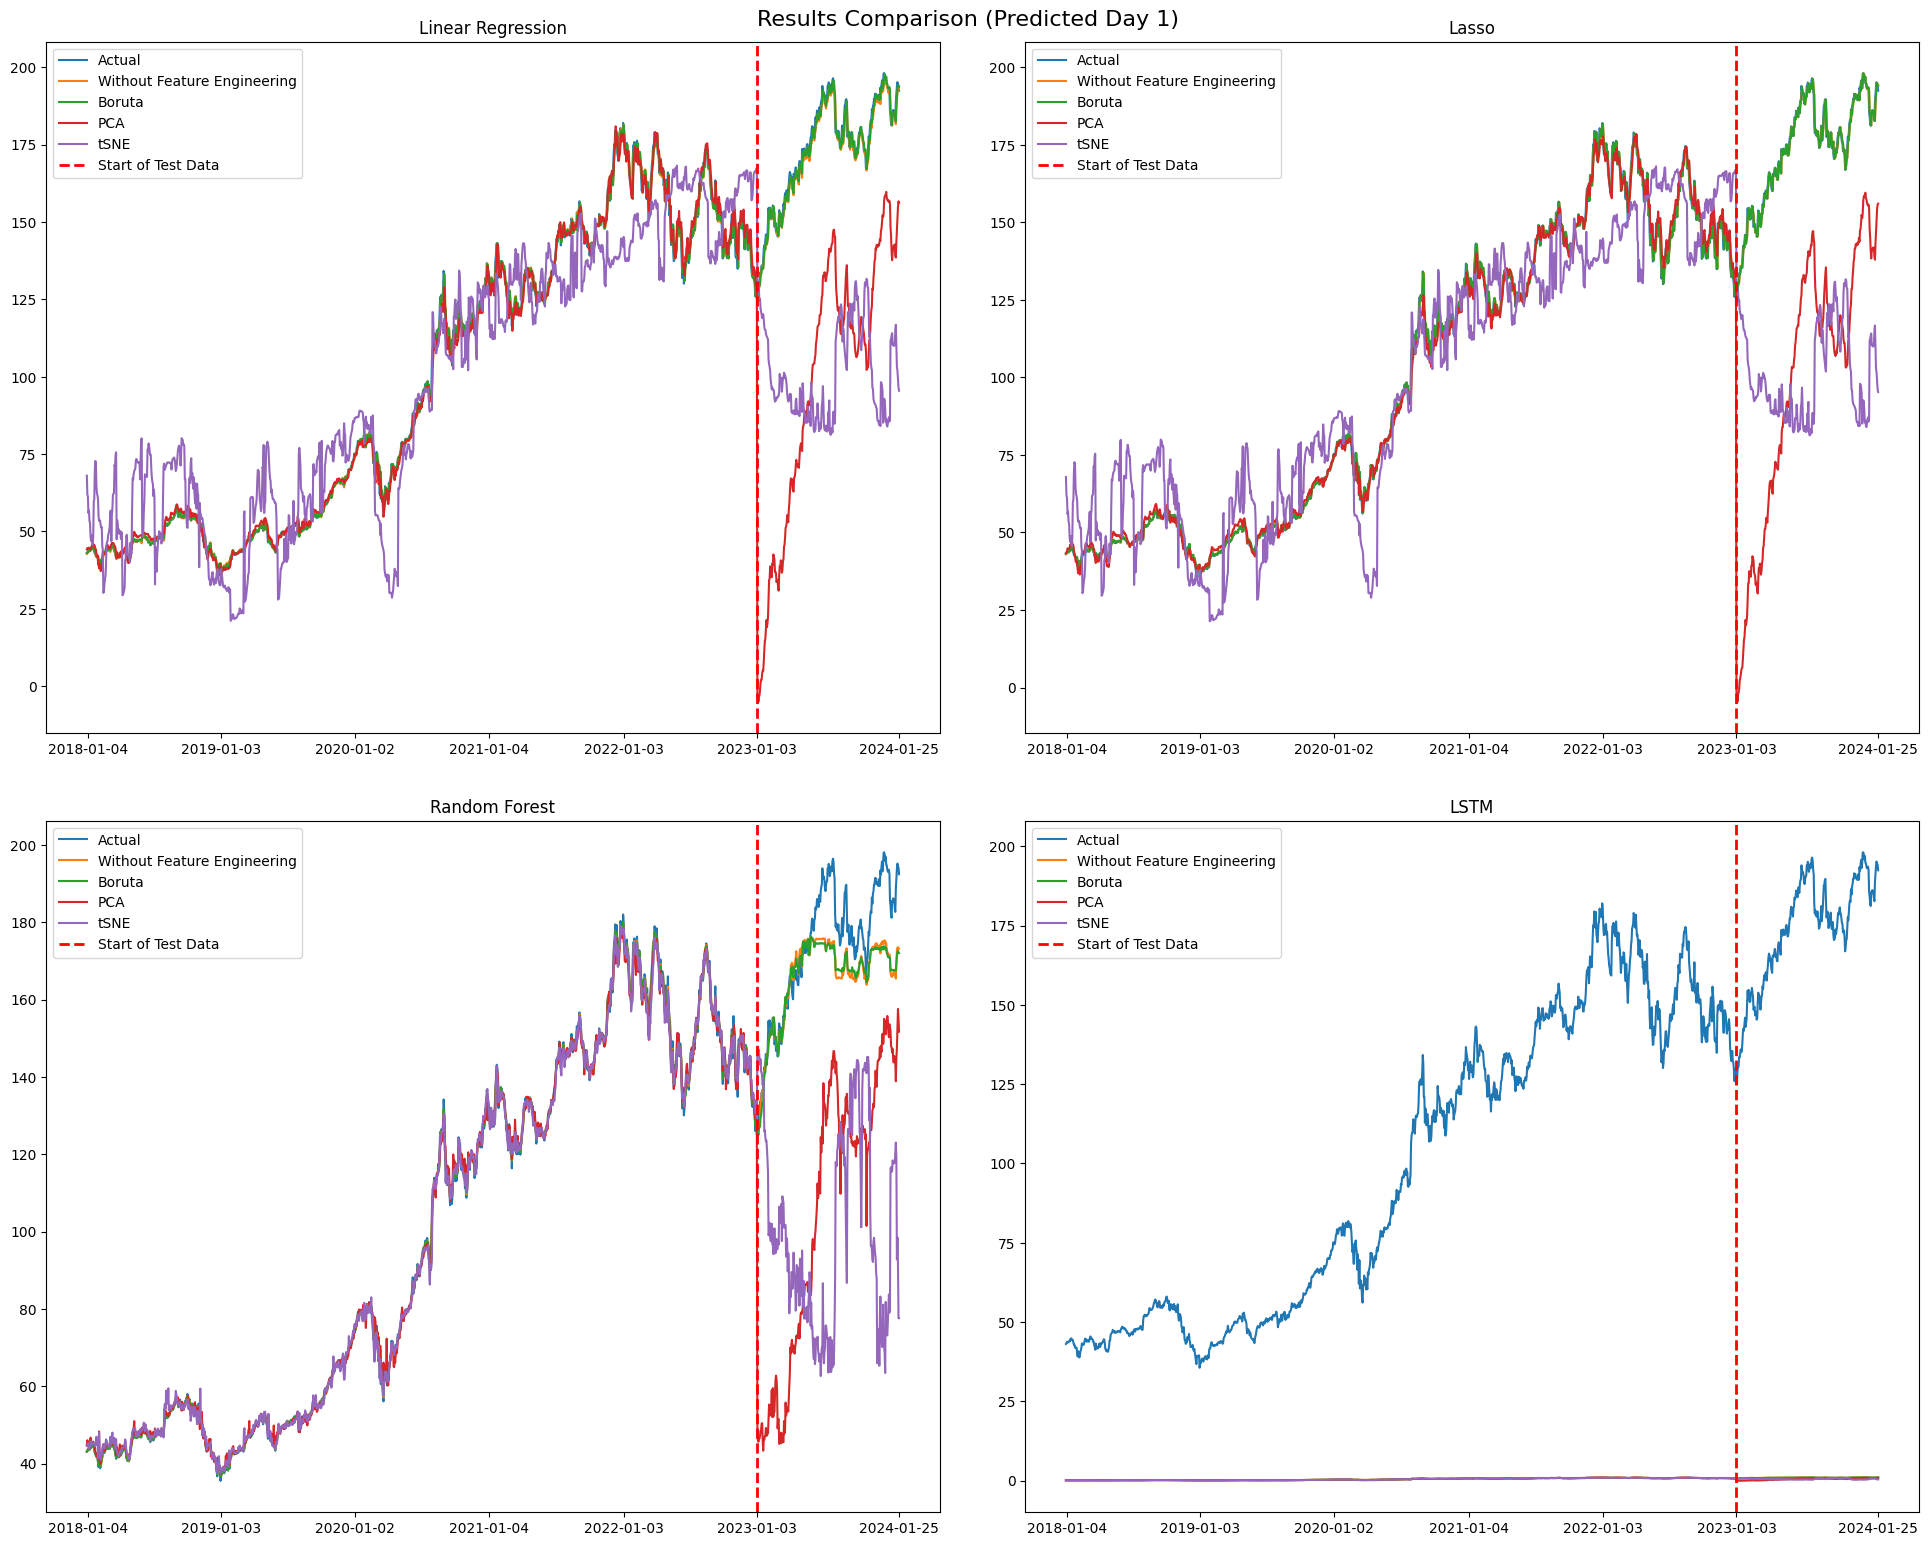

In [3]:
model_name = {0: 'Linear Regression', 1: 'Lasso', 2: 'Random Forest', 3: 'LSTM'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}


# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])

# Without Feature Engineering
print('####### Without Feature Engineering #######')
# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

for trial in range(1, 2):

    print(f'############################################\n\n trial: {trial}\n\n ############################################')

    results_total = []

    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

    print(f'Results {Results}')
    print(f'pred_list {pred_list}')
    results_total.append(Results)

    print('\n\n##################################################\nWithout Feature Engineering')
    print(Results)
    pred_total['Without Feature Engineering'] = pred_list

    # Boruta
    print('\n####### Boruta #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_boruta.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_boruta.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nBoruta')
    print(Results)
    pred_total['Boruta'] = pred_list

    # PCA
    print('\n####### PCA #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_pca.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_pca.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nPCA')
    print(Results)
    pred_total['PCA'] = pred_list

    # t-SNE
    print('\n####### t-SNE #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_tsne.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_tsne.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nt-SNE')
    print(Results)
    pred_total['tSNE'] = pred_list

    # Save Results
    results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

    results_.to_csv(f'./Model performance/results_{trial}.csv')
    # Visualization
    # Before your plotting code, you can adjust the default plot size like this
    plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
    date = np.concatenate((Train_date, Test_date), axis=0)
    axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
    y_actual = np.concatenate((y_train, y_test), axis=0)
    # For each subplot, you can now set individual titles and labels without them overlapping.
    for key, value in model_name.items():
        ax = plt.subplot(2, 2, key + 1)
        model = key
        ax.set_title(value)
        plt.plot(y_actual, label='Actual')
        for key, value in pred_total.items():
            plt.plot(date, value[model], label=key)
        
        # Ensure the x parameter matches the format and actual point where the test data starts
        plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
        
        # Rotate xticks if they are overlapping
        
        # Set xticks to be more sparse to prevent overlap
        #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
        plt.xticks(axis_x)
        plt.legend()

    # Adjust layout spacing to prevent labels and titles from overlapping
    plt.tight_layout(pad=3.0)

    # You can add a super title for the entire figure if you want
    plt.suptitle('Results Comparison (Predicted Day 1)', fontsize=16)

    # Show the plot
    plt.show()

In [4]:
results_

Train MAE  Train RMSE   Test MAE  Test RMSE  \
Without FE 0   1.483713    2.185955   2.103814   2.657183   
           1   1.483569    2.214203   1.680404   2.190981   
           2   0.577567    0.868583   9.297994  11.644006   
           3   0.016287    0.022111   0.059631   0.070492   
Boruta     0   1.479221    2.206673   1.814506   2.350119   
           1   1.484431    2.221659   1.678116   2.190818   
           2   0.558981    0.834292   9.265825  11.757415   
           3   0.017911    0.024599   0.064805   0.075577   
PCA        0   1.925108    2.693755  75.588110  80.690876   
           1   2.077837    2.850734  75.588110  80.643630   
           2   1.201432    1.706148  68.883953  72.562272   
           3   0.015957    0.022695   0.504704   0.534428   
t-SNE      0  12.969487   15.906425  72.819892  77.302222   
           1  12.968160   15.907869  72.814629  77.303395   
           2   1.184341    1.693092  74.408502  81.992195   
           3   0.034654    0.046061   0.484590   0.535494   

                                                    Best Params  
Without FE 0                 {'regressor__fit_intercept': True}  
           1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
           2  {'criterion': 'squared_error', 'max_depth': 16...  
           3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  
Boruta     0                 {'regressor__fit_intercept': True}  
           1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
           2  {'criterion': 'squared_error', 'max_depth': 16...  
           3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  
PCA        0                 {'regressor__fit_intercept': True}  
           1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
           2  {'criterion': 'squared_error', 'max_depth': 16...  
           3  {'batch_size': 64, 'epochs': 50, 'optimizer': ...  
t-SNE      0                 {'regressor__fit_intercept': True}  
           1  {'regressor__alpha': 0.5, 'regressor__max_iter...  
           2  {'criterion': 'squared_error', 'max_depth': 24...  
           3  {'batch_size': 32, 'epochs': 100, 'optimizer':...

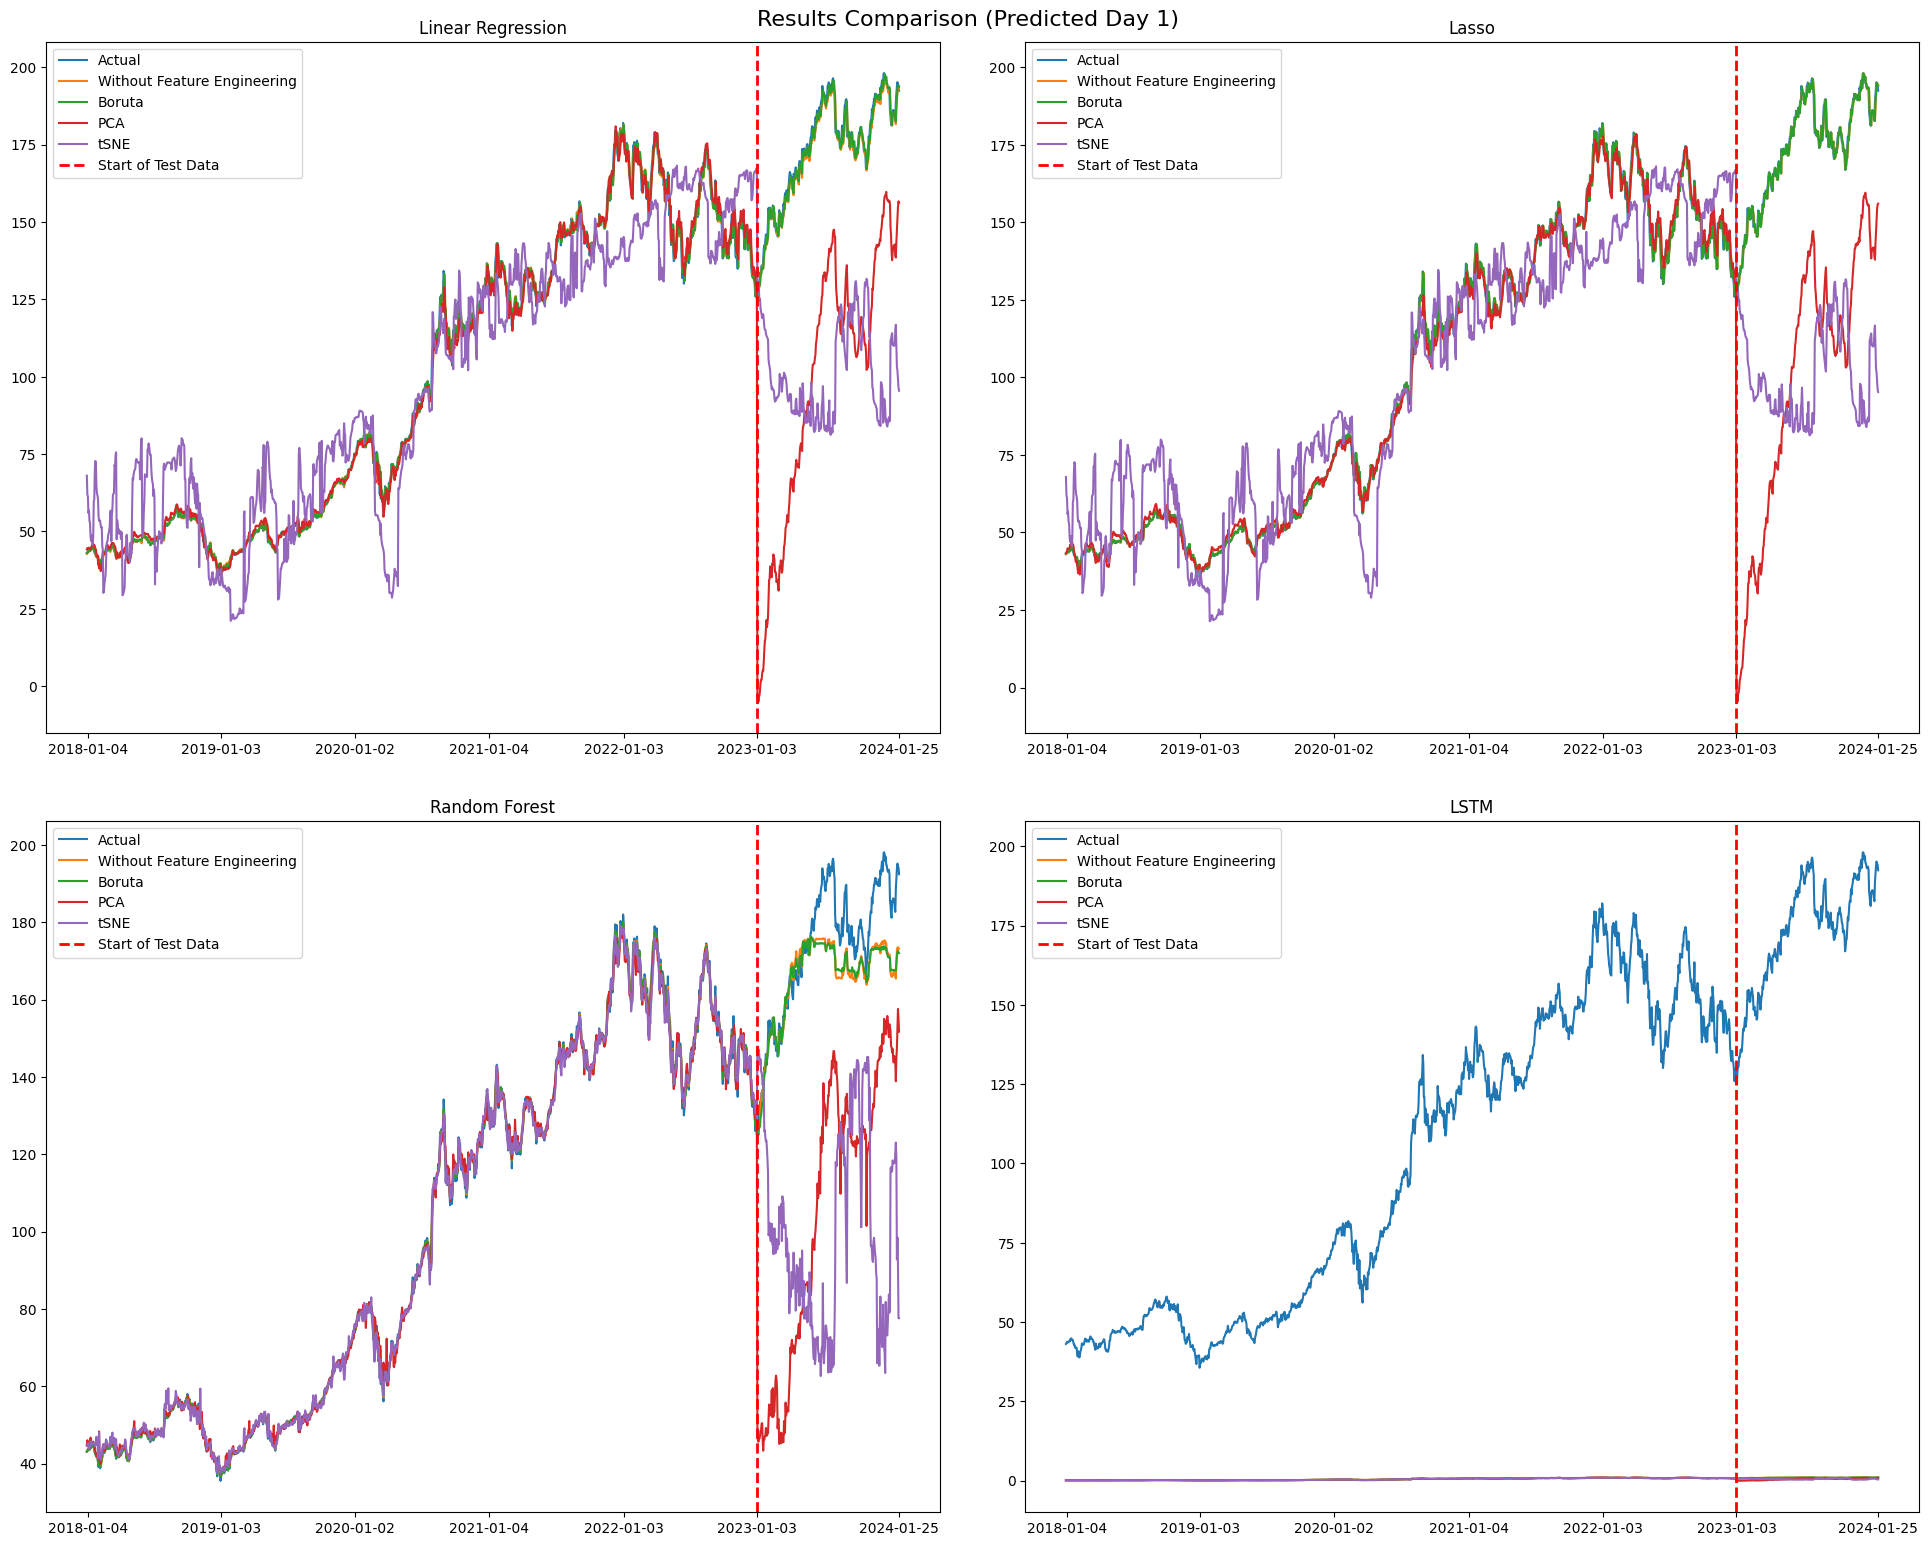

In [5]:
# Before your plotting code, you can adjust the default plot size like this
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)
# For each subplot, you can now set individual titles and labels without them overlapping.
for key, value in model_name.items():
    ax = plt.subplot(2, 2, key + 1)
    model = key
    ax.set_title(value)
    plt.plot(y_actual, label='Actual')
    for key, value in pred_total.items():
        plt.plot(date, value[model], label=key)
    
    # Ensure the x parameter matches the format and actual point where the test data starts
    plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')
    
    # Rotate xticks if they are overlapping
    
    # Set xticks to be more sparse to prevent overlap
    #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
    plt.xticks(axis_x)
    plt.legend()

# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.suptitle('Results Comparison (Predicted Day 1)', fontsize=16)

# Show the plot
plt.show()

In [41]:
pred_list

[array([[68.0275706 ],
        [61.95406168],
        [61.28265979],
        ...,
        [99.07139778],
        [96.45593404],
        [95.45901032]]),
 array([67.87701351, 61.85053392, 61.18588671, ..., 98.811441  ,
        96.24516281, 95.27424644]),
 array([44.58903668, 44.60476246, 45.24855008, ..., 91.46605034,
        77.60538785, 77.61325048]),
 array([[0.08268014],
        [0.07212652],
        [0.07150106],
        ...,
        [0.3604976 ],
        [0.3487432 ],
        [0.34905165]], dtype=float32)]

In [55]:
for pred in pred_list:
    print(pred.shape)



(1526, 1)
(1526,)
(1526,)
(1526, 1)


In [43]:
# ... your previous code

# Assuming scaler_y is already fitted to the y_train data
# Extract LSTM predictions which is the last element in the pred_list
lstm_predictions_normalized = pred_list[-1]  # LSTM predictions are the last item

# Reshape if necessary and apply the inverse transform to the predictions
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_normalized)

# Now `lstm_predictions` contains the predictions on the original scale

# Continue with the plotting
plt.figure(figsize=(20, 16))
dates = np.concatenate((Train_date, Test_date), axis=0)
dates = pd.to_datetime(dates)  # Converting date strings to datetime objects

# Actual values on the original scale (assuming y_train and y_test are already on the original scale)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Plotting for each model
for i, model_key in enumerate(model_name.keys()):
    ax = plt.subplot(2, 2, i+1)
    ax.set_title(model_name[model_key])
    
    # Plot the actual data
    ax.plot(dates, y_actual, label='Actual')
    
    # Check if the current model is LSTM and plot the inverse-transformed predictions
    if model_key == 3:  # Assuming LSTM is model number 3 in your `model_name` dictionary
        ax.plot(dates, lstm_predictions, label='LSTM Predictions')
    else:
        # For other models, just plot the predictions as they are (assuming they are already on the original scale)
        ax.plot(dates, pred_list[i], label=model_name[model_key])

    # Add a vertical line for the start of test data
    ax.axvline(x='2023-01-03', color='r', linestyle='--', label='Start of Test Data')

    ax.legend()

plt.tight_layout()
plt.show()


NameError: name 'scaler_y' is not defined

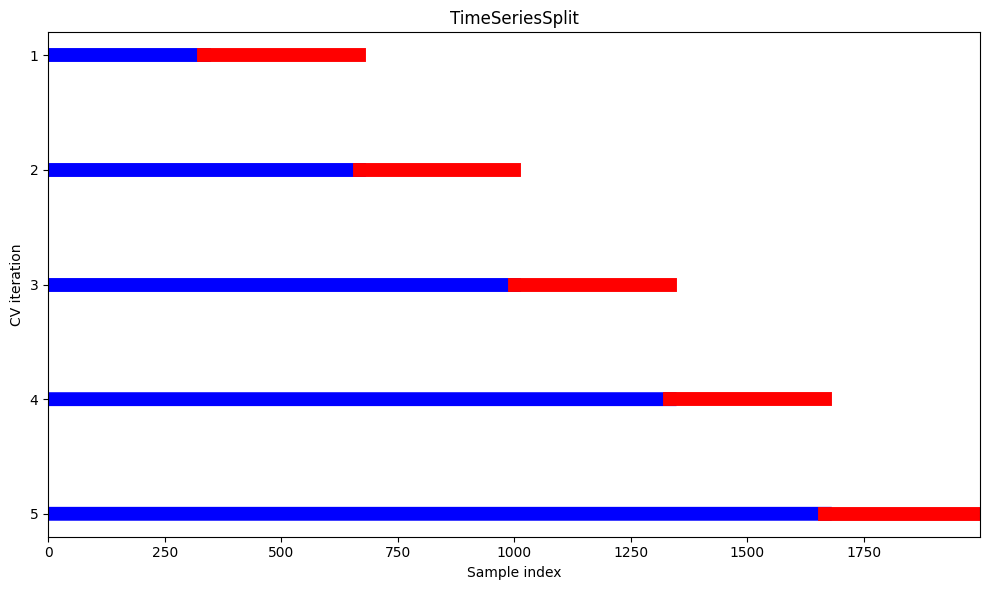

In [36]:
# We will generate the code to create a visualization similar to the provided image, using Python's Matplotlib library.

import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Create a time series dataset
data = np.arange(2000)

# Set up the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Plot the splits
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train, test) in enumerate(tscv.split(data), 1):
    # Plot training indices
    ax.plot(train, [i] * len(train), 'b', linewidth=10, label='Training set' if i == 1 else "")
    # Plot testing indices
    ax.plot(test, [i] * len(test), 'r', linewidth=10, label='Testing set' if i == 1 else "")

# Formatting the plot
ax.set_xlim([0, data[-1]])     
ax.invert_yaxis()  # Reverse the y-axis to count folds from top to bottom
ax.set_xlabel('Sample index')
ax.set_ylabel('CV iteration')
ax.set_yticks(range(1, 6))
ax.set_yticklabels(range(1, 6))
ax.set_title('TimeSeriesSplit')


# Display the plot

plt.tight_layout()
plt.show()




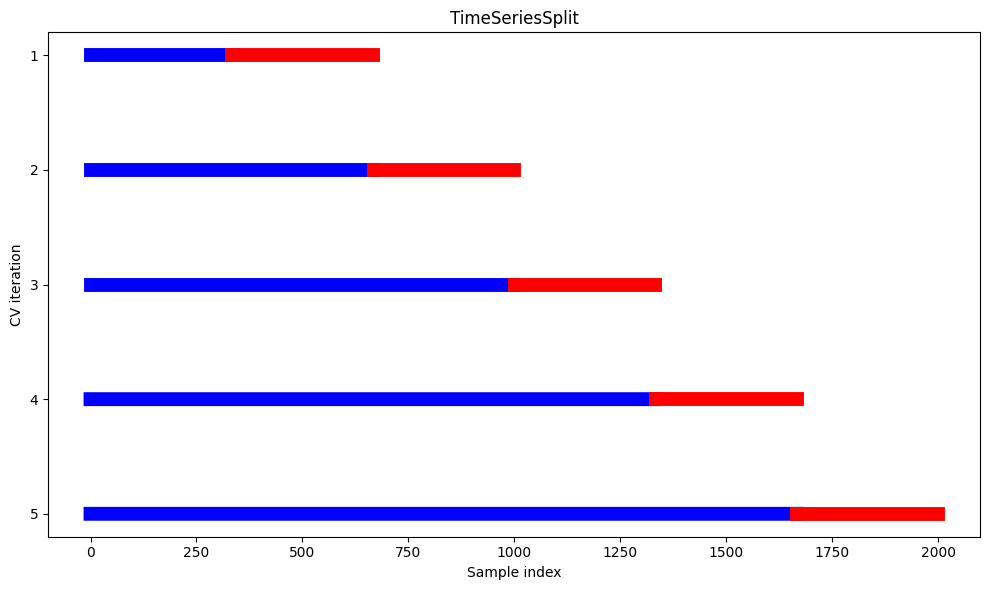

In [40]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Create a time series dataset
data = np.arange(2000)

# Set up the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Plot the splits
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train, test) in enumerate(tscv.split(data), start=1):
    # Plot training indices
    ax.plot(train, [i] * len(train), 'b', linewidth=10, label='Training set' if i == 1 else "")
    # Plot testing indices
    ax.plot(test, [i] * len(test), 'r', linewidth=10, label='Testing set' if i == 1 else "")

# Formatting the plot
ax.invert_yaxis()  # Reverse the y-axis to count folds from top to bottom
#ax.set_xlim([0, data[-1]])  # Set the limit of x-axis to start at 0 and end at the last index of the data
ax.set_xlabel('Sample index')
ax.set_ylabel('CV iteration')
ax.set_yticks(range(1, 6))
ax.set_title('TimeSeriesSplit')

# Display the plot
plt.tight_layout()
plt.show()



In [12]:
!sysctl -n machdep.cpu.brand_string


Apple M2 Pro


In [13]:
!system_profiler SPDisplaysDataType


Graphics/Displays:

    Apple M2 Pro:

      Chipset Model: Apple M2 Pro
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 19
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        Color LCD:
          Display Type: Built-in Liquid Retina XDR Display
          Resolution: 3024 x 1964 Retina
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Automatically Adjust Brightness: Yes
          Connection Type: Internal



In [19]:
!sysctl -n machdep.cpu.brand_string
!system_profiler SPDisplaysDataType
!sysctl hw.memsize
!sw_vers
!python --version

Apple M2 Pro
Graphics/Displays:

    Apple M2 Pro:

      Chipset Model: Apple M2 Pro
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 19
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        Color LCD:
          Display Type: Built-in Liquid Retina XDR Display
          Resolution: 3024 x 1964 Retina
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Automatically Adjust Brightness: Yes
          Connection Type: Internal

hw.memsize: 17179869184
ProductName:		macOS
ProductVersion:		14.2.1
BuildVersion:		23C71
Python 3.10.13


ProductName:		macOS
ProductVersion:		14.2.1
BuildVersion:		23C71
Python 3.10.13


In [16]:
!python --version


Python 3.10.13


In [21]:
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np

print(f"TensorFlow Version: {tf.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")



TensorFlow Version: 2.15.0
Scikit-learn Version: 1.3.1
Pandas Version: 1.5.3
NumPy Version: 1.23.5


!sw_vers
